In [56]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

# Load data

In [57]:
# names
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
sim_tag = "6_moco_clusters_700spots_212361_15mean_15var"
model_tag = "model_resnet18_alpha_0.0_lr_0.0001_weights_False_divergence_l1_seed_42"

In [58]:
import pandas as pd

data_path = os.path.join(PATH, adata_name)
sim_path = os.path.join(data_path, "sim")

#load image_dict
image_dict = torch.load(os.path.join(sim_path, f'{sim_tag}_image_dict_64.pt'))

#load ground truth
ground_truth = pd.read_csv(os.path.join(sim_path, f'{sim_tag}_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [59]:
#load model infos
model_dir = os.path.join('../models/sim-v1', sim_tag, model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

# Analysis

In [60]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer = PredAnalyzer(model_info=model_info,
                        model_state="best",
                        adjusted=False,
                        ground_truth=ground_truth, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


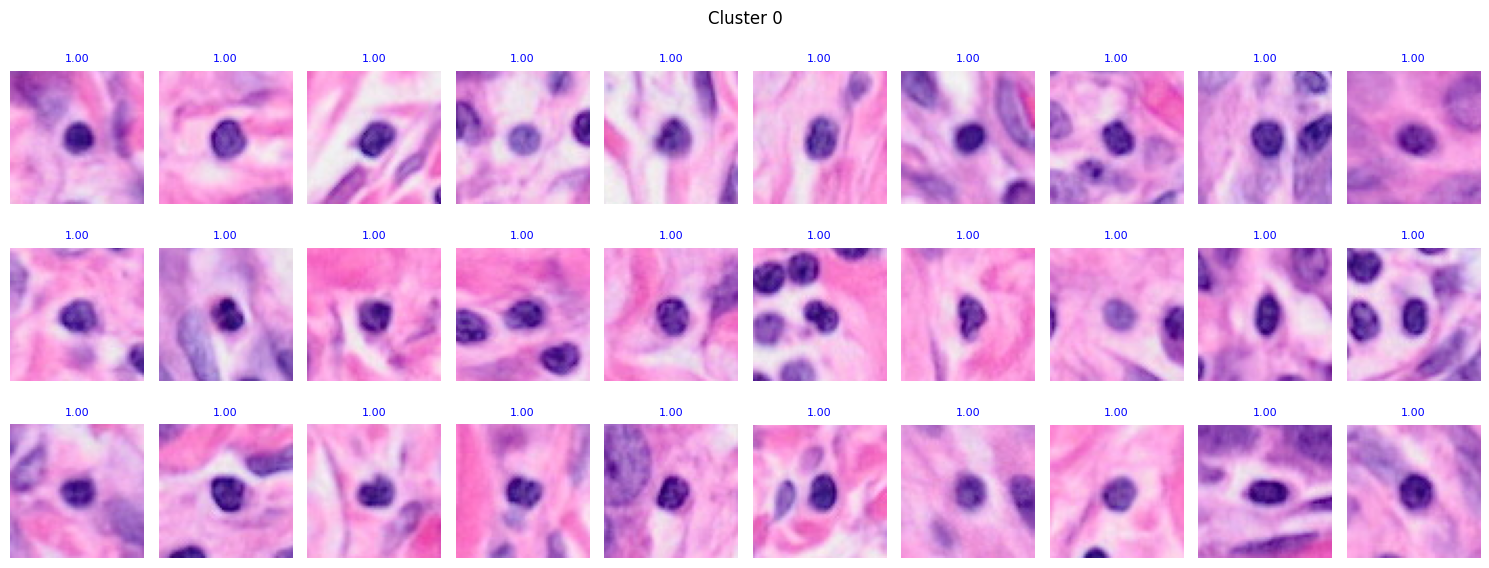

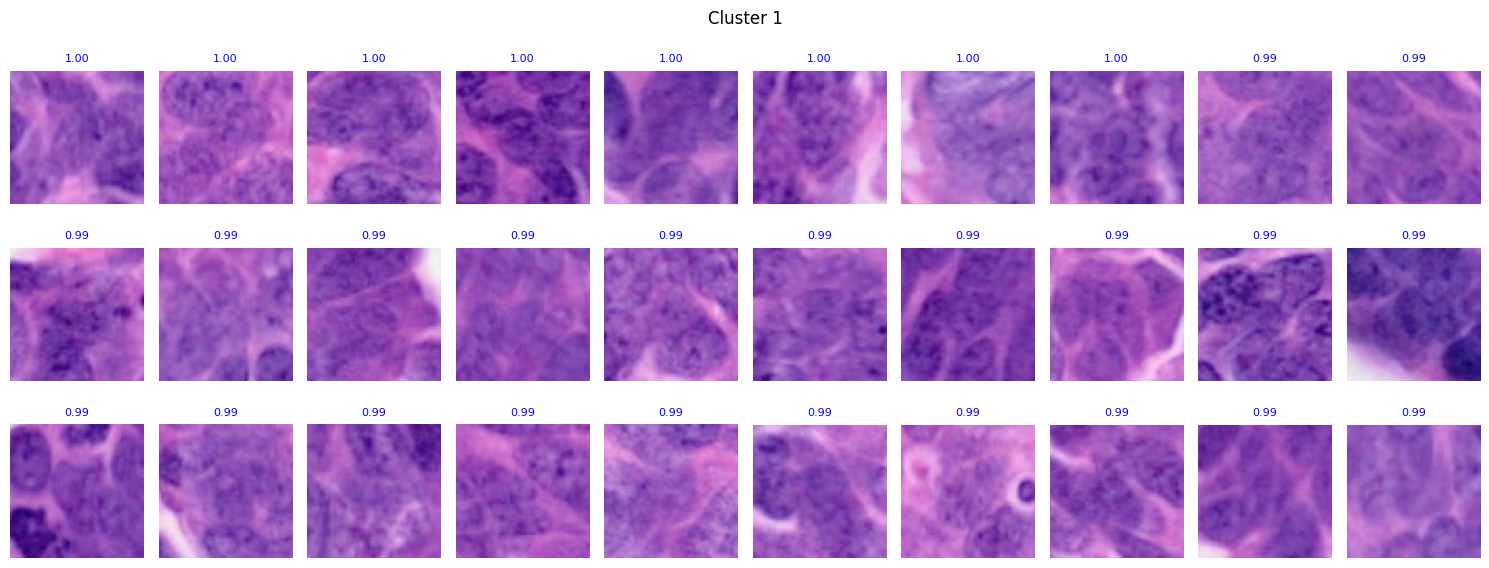

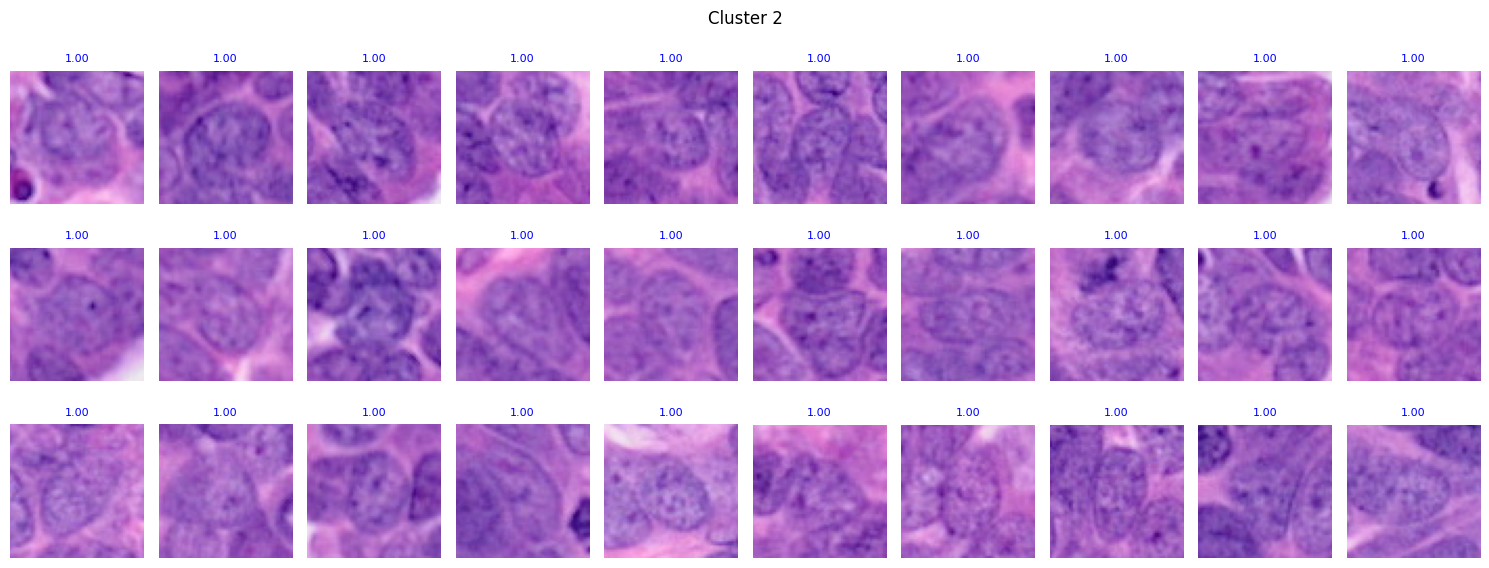

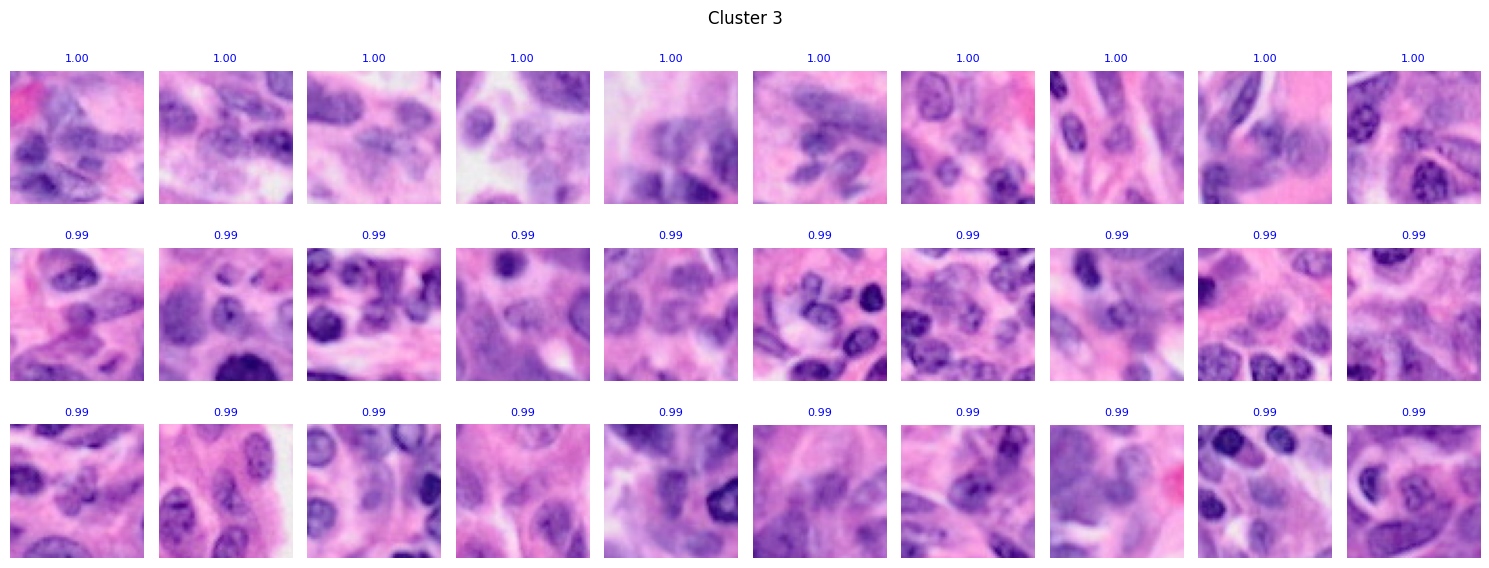

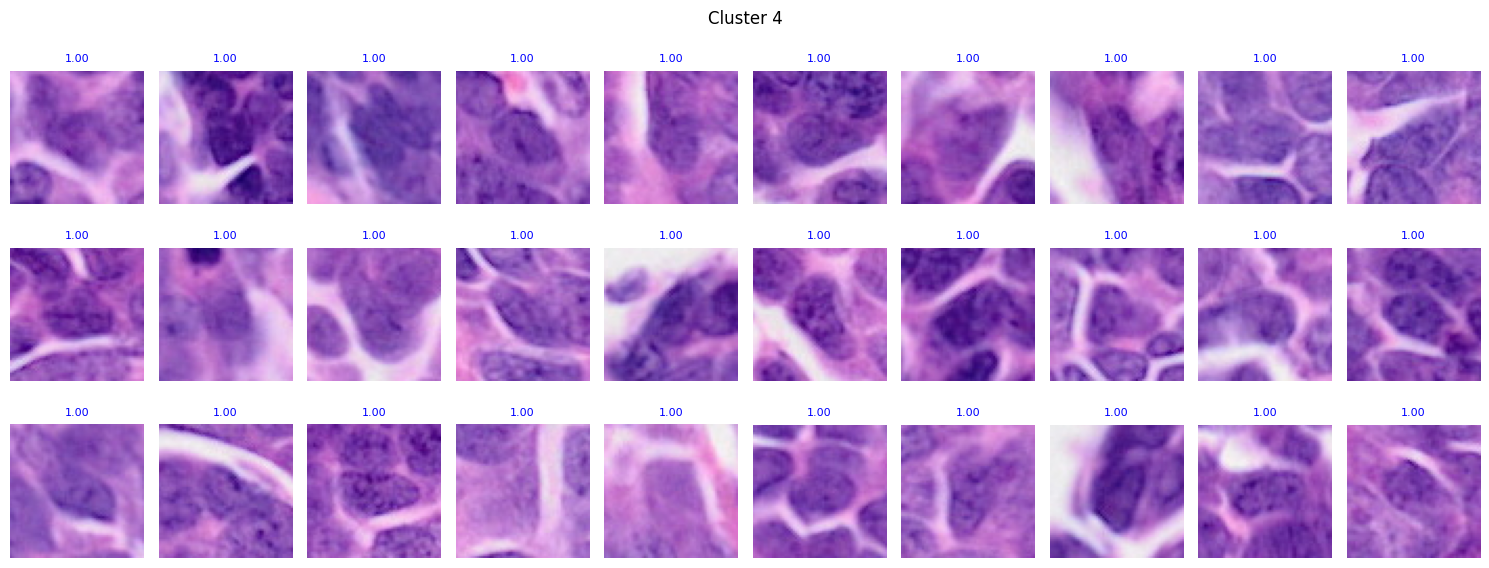

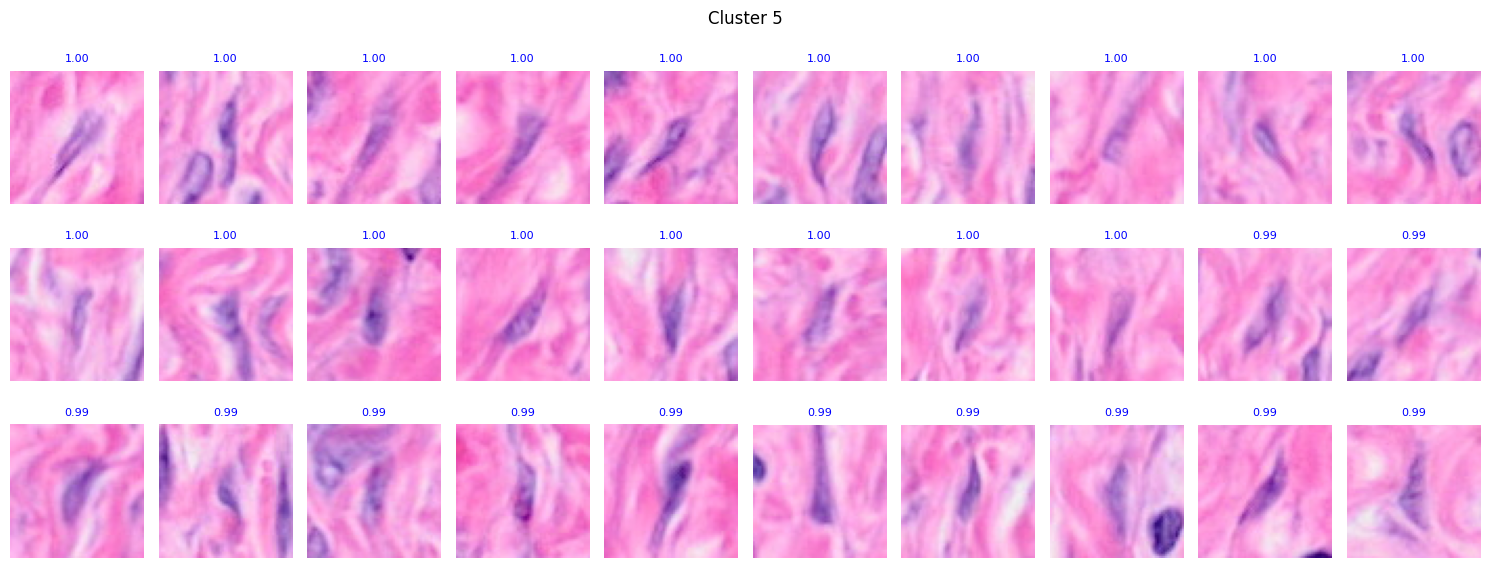

In [23]:
for ct in analyzer.ct_list:
    analyzer.plot_grid_celltype(cell_type=ct, n=30, selection="max", display=True)

Randomly selected spot_id: 766


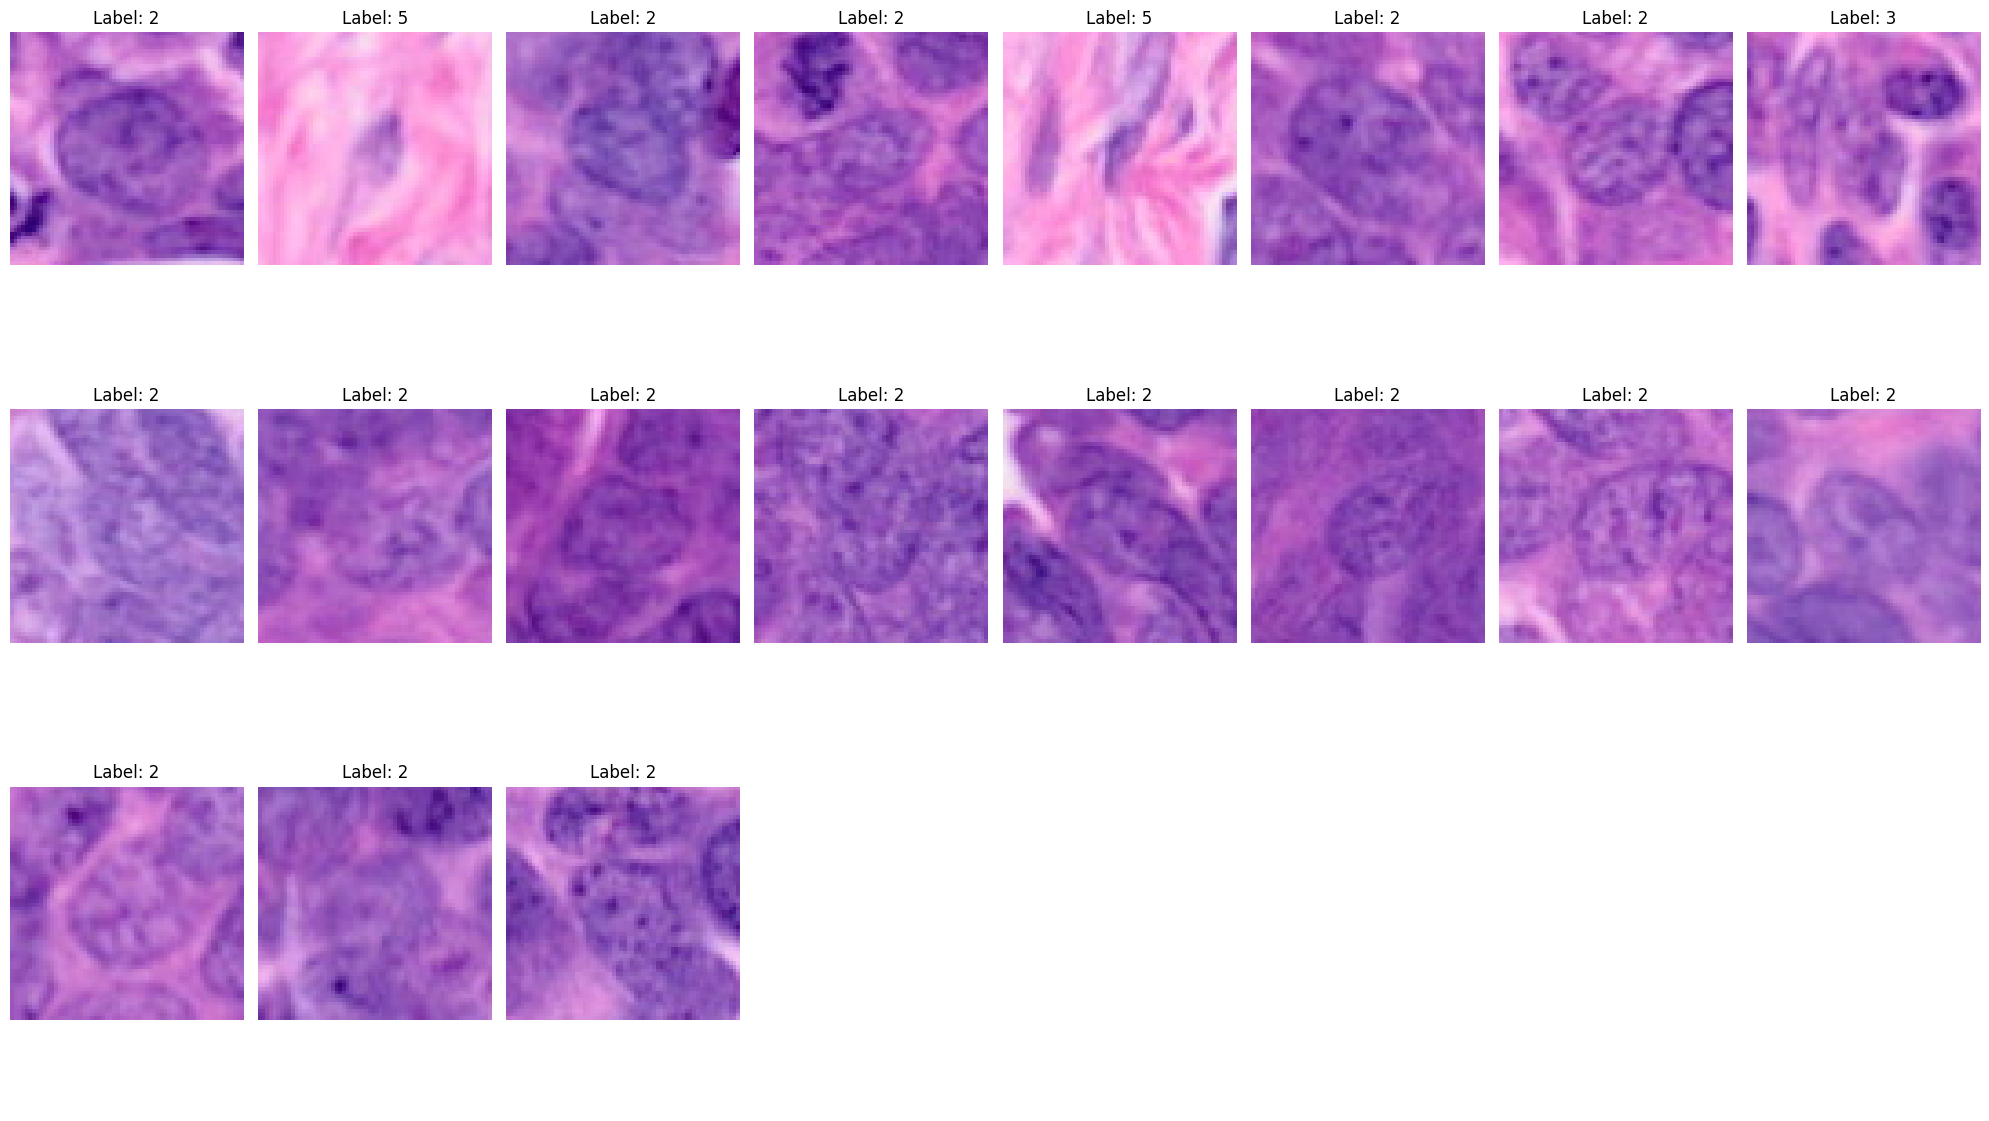

In [24]:
analyzer.plot_mosaic_cells(spot_id=None)

In [58]:
perf_spot = analyzer.evaluate_spot_predictions()
perf_spot

{'Spearman Correlation': 0.7185865894453046,
 'Pearson Correlation': 0.6577611499285014,
 'Weighted MSE': 0.001377001122782226,
 'MSE': 0.014080465343861592,
 'Weighted MAE': 0.009150368569080003,
 'MAE': 0.07443155083962111,
 'R^2 Score': -0.2073017487685553,
 'Balanced Accuracy': 0.7871990784873266,
 'Weighted F1 Score': 0.5724336654294041,
 'Weighted Precision': 0.7838830620069475,
 'Weighted Recall': 0.53}

In [59]:
perf_cell = analyzer.evaluate_cell_predictions()
perf_cell

{'Global Accuracy': 0.964922206506365,
 'Balanced Accuracy': 0.9578406954896139,
 'Weighted F1 Score': 0.9647915250878718,
 'F1 Score (Per Class)': {'Cluster 0': 0.9922594913380022,
  'Cluster 1': 0.9075757575757576,
  'Cluster 2': 0.9816849816849816,
  'Cluster 3': 0.9433811802232854,
  'Cluster 4': 0.968776854769407,
  'Cluster 5': 0.9622641509433962},
 'Weighted Precision': 0.964806328740276,
 'Precision (Per Class)': {'Cluster 0': 0.9933579335793358,
  'Cluster 1': 0.9301242236024845,
  'Cluster 2': 0.9824046920821115,
  'Cluster 3': 0.9441340782122905,
  'Cluster 4': 0.9607954545454546,
  'Cluster 5': 0.9553314121037464},
 'Weighted Recall': 0.964922206506365,
 'Recall (Per Class)': {'Cluster 0': 0.9911634756995582,
  'Cluster 1': 0.886094674556213,
  'Cluster 2': 0.9809663250366032,
  'Cluster 3': 0.9426294820717132,
  'Cluster 4': 0.976891969959561,
  'Cluster 5': 0.9692982456140351},
 'Confusion Matrix':            Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 

In [ ]:
pd.DataFrame(perf_cell["Confusion Matrix"], index=analyzer.ct_list, columns=analyzer.ct_list)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0       1535          0          0          0          0          0
Cluster 1          0        435          0          3          1          0
Cluster 2          0          0       2000          0          0          0
Cluster 3          0          0          0       1762          0          2
Cluster 4          0          0          0          4        438          0
Cluster 5          0          0          0          0          0       1718

# Gridsearch

In [177]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

summary = pd.read_csv("../models/sim/6_moco_clusters_700spots_212361_15mean_15var/summary_metrics_cells_best_adj.csv")
metric_interest = "Balanced Accuracy"

summary.insert(0, "model_name", "")
mid_index = len(summary) // 2
summary.loc[:mid_index, "model_name"] = "resnet18"
summary.loc[mid_index:, "model_name"] = "resnet50"

columns_of_interest = ["model_name", "alpha", "lr", "weights", "divergence", metric_interest]
summary = summary[columns_of_interest]

summary["weights"] = summary["weights"].astype(bool)
summary["alpha"] = summary["alpha"].astype(float)
summary["lr"] = summary["lr"].astype(float)

In [178]:
def plot_balanced_accuracy(model, df, ax):
    subset = df[df["model_name"] == model]
    divergences = subset["divergence"].unique()
    x = np.arange(len(divergences))
    width = 0.12
    
    lr_values = [0.0001, 0.00001]
    num_groups = 8
    
    
    
    for i, alpha in enumerate([0.0, 0.01]):
        for j, lr in enumerate(lr_values):
            for k, weights in enumerate([False, True]):
                color = "#99e699" if alpha == 0.0 else "#66b3ff"
                hatch = "//" if lr == 0.0001 else ""
                marker = "*" if weights else ""
                edgecolor = "black"
                
                values = [
                    subset[
                        (subset["divergence"] == d) & 
                        (subset["weights"] == weights) & 
                        (subset["alpha"] == alpha) & 
                        (subset["lr"] == lr)
                    ][metric_interest].mean()
                    for d in divergences
                ]
                
                group_index = i * 4 + j * 2 + k
                bar_positions = x + (group_index - (num_groups / 2)) * width
                
                bars = ax.bar(bar_positions, values, width, color=color, hatch=hatch, edgecolor=edgecolor, linewidth=0.6)

                for bar in bars:
                    if marker:
                        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), marker,
                                ha='center', fontsize=12, color='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels(divergences)
    ax.set_xlabel("Divergence")
    ax.set_ylabel(metric_interest)
    ax.set_title(f"{model}")

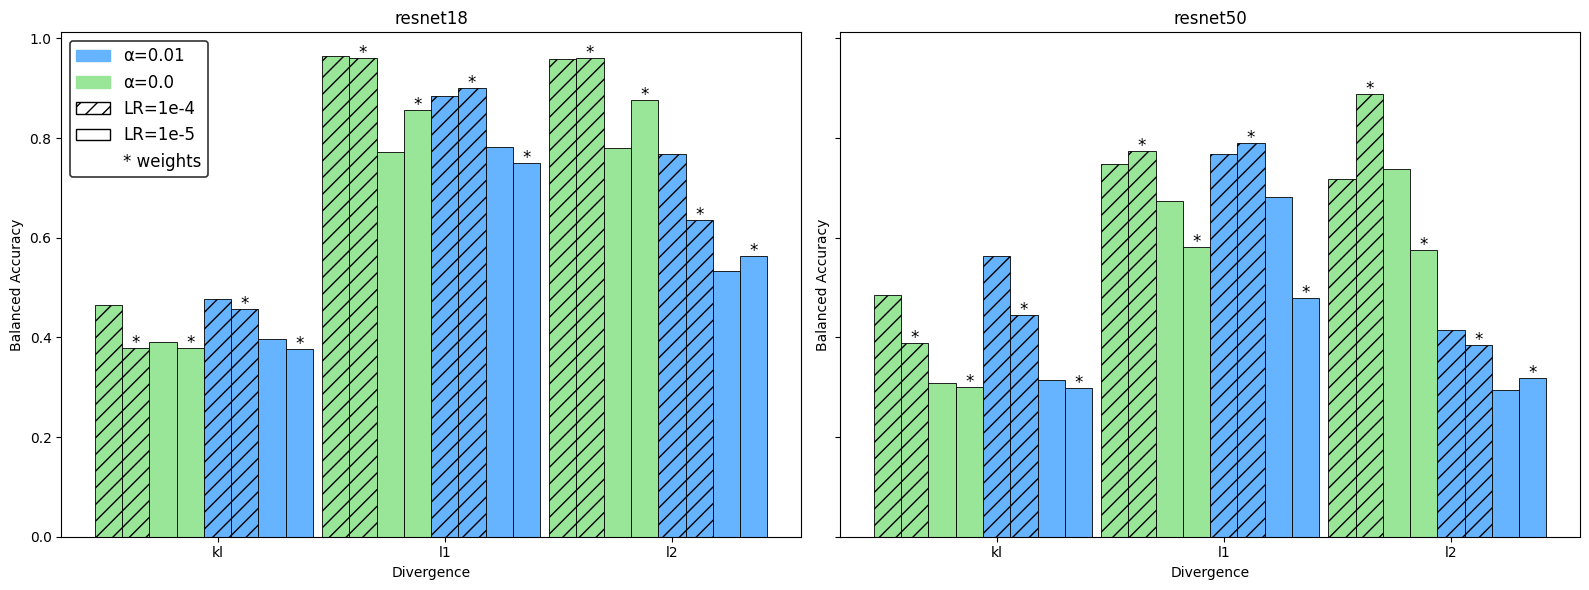

In [179]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plot_balanced_accuracy("resnet18", summary, axes[0])
plot_balanced_accuracy("resnet50", summary, axes[1])

legend_elements = [
    mpatches.Patch(color="#66b3ff", label="α=0.01"),
    mpatches.Patch(color="#99e699", label="α=0.0"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="LR=1e-4"),
    mpatches.Patch(facecolor="white", edgecolor="black", label="LR=1e-5"),
    mpatches.Patch(facecolor="none", edgecolor="none", hatch='*', linewidth=0.8, label="* weights"),
]

legend = axes[0].legend(handles=legend_elements, loc="upper left", fontsize=12, frameon=True, title_fontsize=13)
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.show()

/tmp/ipykernel_95187/1938534518.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_95187/1938534518.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_95187/1938534518.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


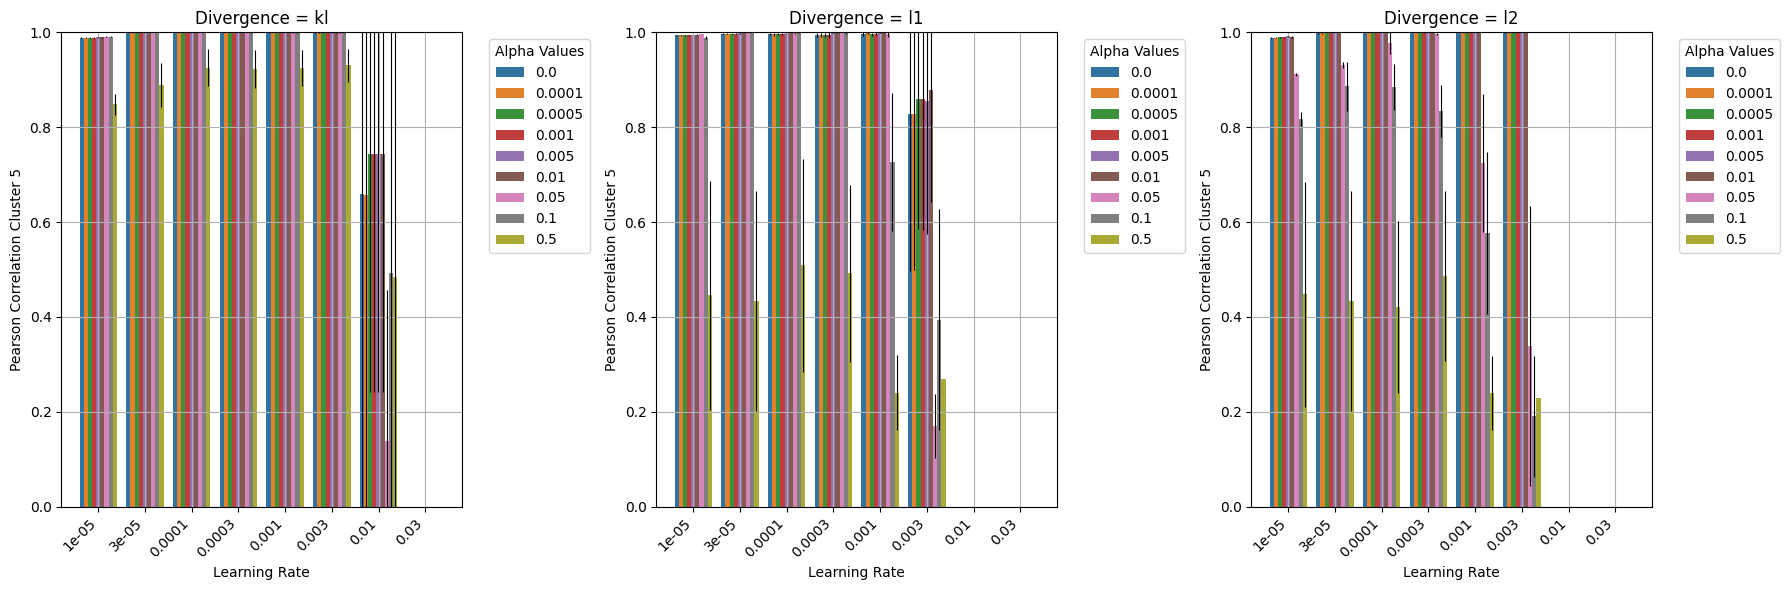

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

balance = "xeniumlike"
level = "slide"
subset = ""  # '_no_train' or '_train'
metric = "Pearson Correlation Cluster 5"
adjusted = True

adj = "_adj" if adjusted else ""
metric_ci = f"{metric} ci"
data = pd.read_csv(
    f'../models/quick-sim-v2-2/6_moco_clusters_700spots_{balance}_15mean_15var/summary_metrics_{level}_best{adj}{subset}.csv'
)
data['lr'] = data['lr'].astype(float)

# Fill NaN values with 0 for plotting
data[metric] = data[metric].fillna(0)
data[metric_ci] = data[metric_ci].fillna(0)

divergences = ['kl', 'l1', 'l2']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, divergence in enumerate(divergences):
    ax = axes[i]

    divergence_data = data[data['divergence'] == divergence].sort_values(by=['alpha', 'lr'])

    sns.barplot(
        x='lr',
        y=metric,
        hue='alpha',
        data=divergence_data,
        ax=ax,
        palette='tab10',
        order=sorted(divergence_data['lr'].unique())
    )

    for bar, (lr, alpha) in zip(ax.patches, zip(divergence_data['lr'], divergence_data['alpha'])):
        lr_center = bar.get_x() + bar.get_width() / 2.1
        y_val = bar.get_height()

        subset = divergence_data[(divergence_data['lr'] == lr) & (divergence_data['alpha'] == alpha)]

        if not subset.empty:
            y_err = subset[metric_ci].values[0]

            ax.errorbar(
                lr_center, y_val, yerr=y_err, fmt='none',
                ecolor='black', capsize=3, capthick=0, elinewidth=0.8
            )

    ax.set_title(f'Divergence = {divergence}')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel(metric)
    ax.legend(title='Alpha Values', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_28047/1564992413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_28047/1564992413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_28047/1564992413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


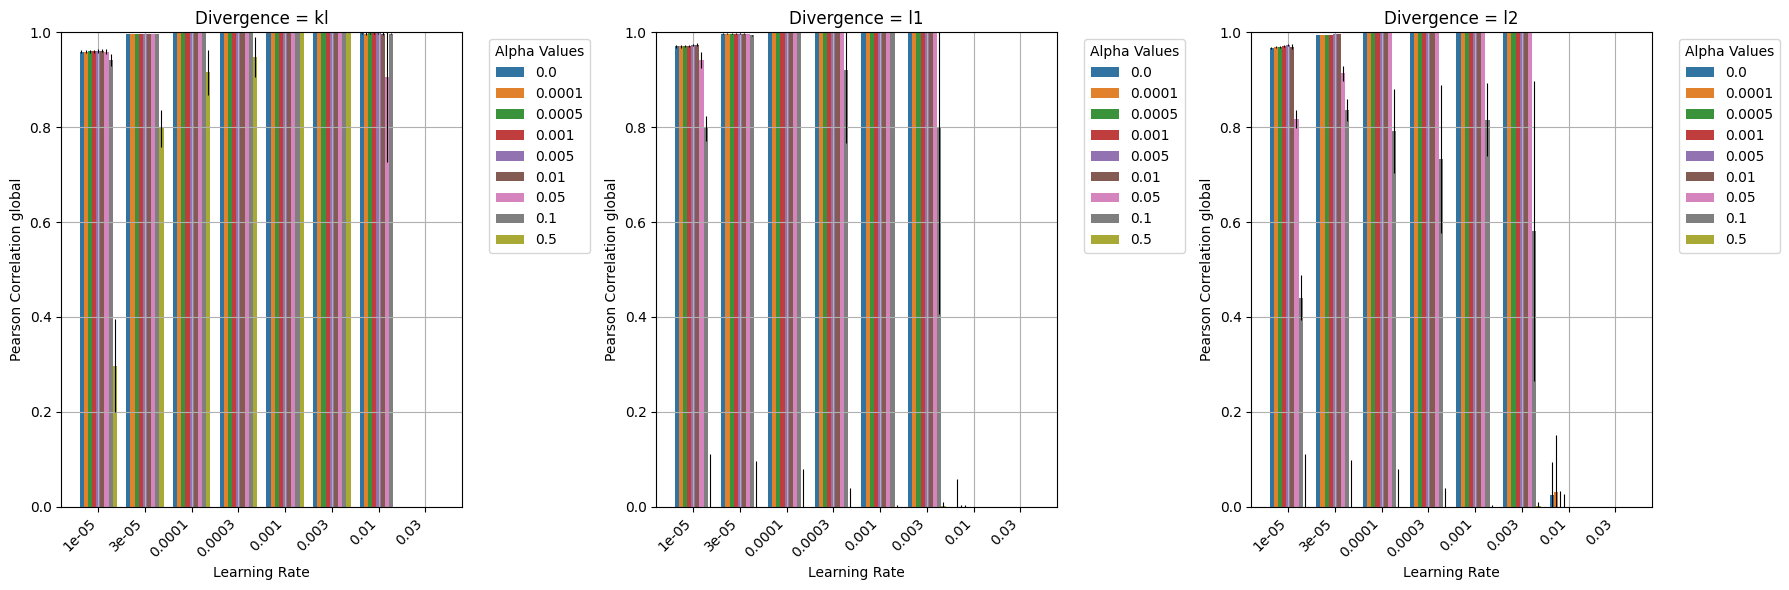

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

balance = "balanced"
level = "slide"
subset = ""  # '_no_train' or '_train'
metric = "Pearson Correlation global"

metric_ci = f"{metric} ci"
data = pd.read_csv(
    f'../models/test/summary_metrics_{level}_best{subset}.csv'
)
data['lr'] = data['lr'].astype(float)

# Fill NaN values with 0 for plotting
data[metric] = data[metric].fillna(0)
data[metric_ci] = data[metric_ci].fillna(0)

divergences = ['kl', 'l1', 'l2']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, divergence in enumerate(divergences):
    ax = axes[i]

    divergence_data = data[data['divergence'] == divergence].sort_values(by=['alpha', 'lr'])

    sns.barplot(
        x='lr',
        y=metric,
        hue='alpha',
        data=divergence_data,
        ax=ax,
        palette='tab10',
        order=sorted(divergence_data['lr'].unique())
    )

    for bar, (lr, alpha) in zip(ax.patches, zip(divergence_data['lr'], divergence_data['alpha'])):
        lr_center = bar.get_x() + bar.get_width() / 2.1
        y_val = bar.get_height()

        subset = divergence_data[(divergence_data['lr'] == lr) & (divergence_data['alpha'] == alpha)]

        if not subset.empty:
            y_err = subset[metric_ci].values[0]

            ax.errorbar(
                lr_center, y_val, yerr=y_err, fmt='none',
                ecolor='black', capsize=3, capthick=0, elinewidth=0.8
            )

    ax.set_title(f'Divergence = {divergence}')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel(metric)
    ax.legend(title='Alpha Values', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Tests

In [3]:
model_dir = os.path.join('../models/sim/6_moco_clusters_700spots_212361_15mean_15var/model_resnet18_alpha_0.0_lr_0.0001_weights_False_divergence_l1_seed_42')

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [4]:
from deconvplugin.dataset import SpotDataset
from deconvplugin.dataset_utils import custom_collate
from deconvplugin.dataset_utils import split_data

spot_dict = model_info["spot_dict"]
spot_prop_df = model_info["proportions"]

train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
        spot_dict, spot_prop_df, train_size=0.7, val_size=0.15, rs=42
    )

train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict, None)
val_dataset = SpotDataset(val_spot_dict, val_proportions, image_dict, None)
test_dataset = SpotDataset(test_spot_dict, test_proportions, image_dict, None)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=custom_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=custom_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=custom_collate)

NameError: name 'image_dict' is not defined

In [22]:
cells_list = set()
for cell_list in spot_dict.values():
    cells_list.update(cell_list)
cells_list = list(cells_list)

In [8]:
len(spot_prop_df.values.flatten())

4200

In [23]:
analyzer.evaluate_cell_predictions()

{'Global Accuracy': 0.964922206506365,
 'Balanced Accuracy': 0.9578406954896139,
 'Weighted F1 Score': 0.9647915250878718,
 'F1 Score (Per Class)': {'Cluster 0': 0.9922594913380022,
  'Cluster 1': 0.9075757575757576,
  'Cluster 2': 0.9816849816849816,
  'Cluster 3': 0.9433811802232854,
  'Cluster 4': 0.968776854769407,
  'Cluster 5': 0.9622641509433962},
 'Weighted Precision': 0.964806328740276,
 'Precision (Per Class)': {'Cluster 0': 0.9933579335793358,
  'Cluster 1': 0.9301242236024845,
  'Cluster 2': 0.9824046920821115,
  'Cluster 3': 0.9441340782122905,
  'Cluster 4': 0.9607954545454546,
  'Cluster 5': 0.9553314121037464},
 'Weighted Recall': 0.964922206506365,
 'Recall (Per Class)': {'Cluster 0': 0.9911634756995582,
  'Cluster 1': 0.886094674556213,
  'Cluster 2': 0.9809663250366032,
  'Cluster 3': 0.9426294820717132,
  'Cluster 4': 0.976891969959561,
  'Cluster 5': 0.9692982456140351},
 'Confusion Matrix':            Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 

In [51]:
cell_to_spot = {cell: spot for spot, cells in analyzer.spot_dict.items() for cell in cells}

In [55]:
spot_unique = []
for cell, spot in cell_to_spot.items():
    if spot not in spot_unique:
        spot_unique.append(spot)
len(spot_unique)

700

In [57]:
# Looking for cells duplicated in spot_dict values
unique_cells = []
duplicated_cells = []
for cell_list in analyzer.spot_dict.values():
    for cell in cell_list:
        if cell not in unique_cells:
            unique_cells.append(cell)
        else:
            duplicated_cells.append(cell)

In [61]:
for spot, cell_list in analyzer.spot_dict.items():
    for cell in cell_list:
        if cell == '1145':
            print(f"Spot: {spot}")

Spot: 0
Spot: 1
Spot: 101
Spot: 673


In [35]:
from scipy.stats import pearsonr

plist = []
for cl in ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]:
    pearson_corr = pearsonr(analyzer.predicted_proportions[cl], analyzer.proportions[cl])
    plist.append(pearson_corr[0])

In [36]:
plist

[0.9938977835770703,
 0.9146457420344921,
 0.9830440151940231,
 0.9542582895428134,
 0.9769335929371841,
 0.9666926087788716]

In [37]:
import numpy as np
np.nanmean(plist)

0.9649120053440758

In [120]:
from torch_scatter import scatter_mean
outputs = torch.tensor([[0.2, 0.4, 0.1, 0.1, 0.2],
                       [0.3, 0.1, 0.1, 0.4, 0.1],
                       [0.1, 0.2, 0.3, 0.3, 0.1],
                       [0.2, 0.1, 0.1, 0.1, 0.5]])
true_proportions_good = torch.tensor([[0.2, 0.2, 0.12, 0.3, 0.18],
                                  [0.1, 0.2, 0.3, 0.3, 0.1],
                                  [0.18, 0.12, 0.13, 0.07, 0.5]])
true_proportions_bad = torch.tensor([[0.6, 0.1, 0.1, 0.1, 0.1],
                                  [0, 0.1, 0.3, 0.1, 0.5],
                                  [0.05, 0.2, 0.5, 0.2, 0.05]])
weights = torch.ones_like(true_proportions_good)[0]
bag_indices = torch.tensor([0, 0, 1, 2])
pred_proportions = scatter_mean(outputs, bag_indices, dim=0)

In [119]:
from deconvplugin.loss import weighted_kl_divergence
divergence_loss = weighted_kl_divergence(pred_proportions, true_proportions_bad, weights=weights)
divergence_loss

tensor(0.3755)

In [118]:
(weighted_kl_divergence(pred_proportions[0], true_proportions_bad[0], weights=weights) + \
weighted_kl_divergence(pred_proportions[1], true_proportions_bad[1], weights=weights) + \
weighted_kl_divergence(pred_proportions[2], true_proportions_bad[2], weights=weights)) / 3

tensor(0.3755)

In [117]:
from torch.nn import KLDivLoss

cell_proportion = torch.tensor([0.1, 0.2, 0.3, 0.4])
cell_pred = torch.tensor([0.11, 0.18, 0.35, 0.35])
kl_div = KLDivLoss()
kl_div(cell_pred.log(), cell_proportion)

tensor(0.0047)

In [13]:
spot_proportions = {}

for spot_id, cell_ids in analyzer.spot_dict.items():
    spot_cells = analyzer.predictions.loc[analyzer.predictions.index.isin(cell_ids)]
    spot_proportions[spot_id] = spot_cells.mean(axis=0)

predicted_proportions_df = pd.DataFrame.from_dict(spot_proportions, orient="index")
predicted_proportions_df.index.name = "spot"
predicted_proportions_df

Cluster 0     Cluster 1     Cluster 2     Cluster 3  Cluster 4  \
spot                                                                      
0     1.666711e-01  5.555586e-02  5.555557e-02  2.222118e-01   0.500006   
1     9.090925e-02  9.091187e-02  9.090910e-02  1.460656e-01   0.535749   
2     1.538517e-01  2.861745e-05  7.692345e-02  1.539692e-01   0.538304   
3     5.000000e-01  1.589116e-08  6.272652e-10  4.318804e-08   0.500000   
4     1.538461e-01  7.692402e-02  7.692296e-02  2.307455e-01   0.461561   
...            ...           ...           ...           ...        ...   
695   2.727282e-01  9.084721e-02  1.818800e-01  2.727208e-01   0.090910   
696   5.003511e-07  5.475794e-02  2.105261e-01  2.631489e-01   0.313665   
697   1.176472e-01  6.278945e-08  1.764706e-01  1.764707e-01   0.411765   
698   2.083333e-01  8.333464e-02  4.166667e-02  2.916666e-01   0.333332   
699   1.842753e-01  5.559113e-02  1.111082e-01  1.154240e-01   0.532097   

         Cluster 5  
spot                
0     7.802456e-08  
1     4.545536e-02  
2     7.692341e-02  
3     5.190509e-08  
4     2.461423e-08  
...            ...  
695   9.091369e-02  
696   1.579017e-01  
697   1.176467e-01  
698   4.166668e-02  
699   1.504510e-03  

[700 rows x 6 columns]

In [63]:
spot_proportions = {}

for spot_id, cell_ids in analyzer.spot_dict.items():
    spot_cells = analyzer.predictions.loc[analyzer.predictions.index.isin(cell_ids)]
    spot_proportions[spot_id] = spot_cells.mean(axis=0)

predicted_proportions_df = pd.DataFrame.from_dict(spot_proportions, orient="index")
predicted_proportions_df.index.name = "spot"
predicted_proportions_df

Cluster 0     Cluster 1     Cluster 2     Cluster 3  Cluster 4  \
spot                                                                      
0     1.666711e-01  5.555586e-02  5.555557e-02  2.222118e-01   0.500006   
1     9.090925e-02  9.091187e-02  9.090910e-02  1.460656e-01   0.535749   
2     1.538517e-01  2.861745e-05  7.692345e-02  1.539692e-01   0.538304   
3     5.000000e-01  1.589116e-08  6.272652e-10  4.318804e-08   0.500000   
4     1.538461e-01  7.692402e-02  7.692296e-02  2.307455e-01   0.461561   
...            ...           ...           ...           ...        ...   
695   2.727282e-01  9.084721e-02  1.818800e-01  2.727208e-01   0.090910   
696   5.003511e-07  5.475794e-02  2.105261e-01  2.631489e-01   0.313665   
697   1.176472e-01  6.278945e-08  1.764706e-01  1.764707e-01   0.411765   
698   2.083333e-01  8.333464e-02  4.166667e-02  2.916666e-01   0.333332   
699   1.842753e-01  5.559113e-02  1.111082e-01  1.154240e-01   0.532097   

         Cluster 5  
spot                
0     7.802456e-08  
1     4.545536e-02  
2     7.692341e-02  
3     5.190509e-08  
4     2.461423e-08  
...            ...  
695   9.091369e-02  
696   1.579017e-01  
697   1.176467e-01  
698   4.166668e-02  
699   1.504510e-03  

[700 rows x 6 columns]

In [68]:
train_spots = list(analyzer.spot_dict.keys())[:20]